In [2]:
import re, os
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import pickle

from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy

# Plotting tools
from matplotlib.colors import LinearSegmentedColormap, Normalize
from PIL import Image
%matplotlib inline

from openai import AzureOpenAI

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import dotenv
dotenv.load_dotenv()

True

In [4]:
home = os.getenv("HOME")
os.environ.update({'MALLET_HOME':r'/home/users/iasamori/tiktok/mallet-2.0.8/'})
mallet_path = f"{home}/tiktok/mallet-2.0.8/bin/mallet"

In [5]:
scratch = os.getenv('SCRATCH')
embedding_folder = f"{scratch}/samori/tiktok/embeddings"

with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
    emb_dict_small = pickle.load(f)

with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
    emb_dict_large = pickle.load(f)

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [7]:
data = pd.read_csv("../combined_comments_3.csv", encoding='utf-8')
data = data.dropna(subset=['text'])
data = data.rename(columns={'text': 'message', 'id':'message_id'})
data = data.reset_index()

threshold = 3
data['message_split'] = [i.split(' ') for i in data['message']]
lengths = [len(i) for i in data['message_split']]

drop_ids = [i for i in range(len(lengths)) if lengths[i] < threshold]
data = data.drop(drop_ids)
data = data.drop(['message_split', 'index'], axis=1)
data = data.reset_index().drop(['index'], axis=1)
data

,create_time,message_id,like_count,parent_comment_id,reply_count,message,video_id
0,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,many of them have no idea they are using fenta...,7.260153e+18
1,1.698725e+09,7.295968e+18,0.0,7.260153e+18,0.0,your children are spiritual warefare!,7.260153e+18
2,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,i pray they never havevto understand our pain,7.260153e+18
3,1.699370e+09,7.298738e+18,0.0,7.298692e+18,0.0,how ya doing,7.298692e+18
4,1.673488e+09,7.187574e+18,0.0,7.187541e+18,0.0,Thank you so much,7.187435e+18
...,...,...,...,...,...,...,...
69062,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,of course massive corporations are exploiting ...,7.255007e+18
69063,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,there is no justification for it. someone who ...,7.255007e+18
69064,1.690227e+09,7.259469e+18,1.0,7.255254e+18,0.0,I’m honestly not one to hate on anyone. I can ...,7.255007e+18
69065,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,in what world do you actually think it’s cool ...,7.255007e+18


In [8]:
def process(data_text):
    data_text = [re.sub('\S*@\S*\s?', '', sent) for sent in data_text] # remove emails
    data_text = [re.sub('\+?\d[\d .-]{8,}\d', '', sent) for sent in data_text] #remove phone numbers
    data_text = [re.sub('\s+', ' ', sent) for sent in data_text] # remove newlines
    data_text = [re.sub("\'", "", sent) for sent in data_text] # reomve single quotes

    tokenize_data_text = [gensim.utils.simple_preprocess(str(sent), deacc=True) for sent in data_text]

    return tokenize_data_text

In [9]:
data_text_tokenized = process(data.message)

print(len(data_text_tokenized))
print(data_text_tokenized[:5])

69067
[['many', 'of', 'them', 'have', 'no', 'idea', 'they', 'are', 'using', 'fentanyl'], ['your', 'children', 'are', 'spiritual', 'warefare'], ['pray', 'they', 'never', 'havevto', 'understand', 'our', 'pain'], ['how', 'ya', 'doing'], ['thank', 'you', 'so', 'much']]


In [10]:
bigram = gensim.models.Phrases(data_text_tokenized, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_text_tokenized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_text_tokenized[5]]])

['happy_birthday', 'jackson', 'hope', 'you', 're', 'spending', 'it', 'visiting', 'your', 'momma', 'that', 'misses', 'you', 'more', 'and', 'more', 'every', 'day']


In [11]:
def get_ngram_lemmatize(data_text, make_bigram=True, make_trigram=False, 
                        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    data_text = [[word for word in text if word not in stop_words] for text in data_text]
    
    if make_bigram:
        data_text = [bigram_mod[doc] for doc in tqdm(data_text, desc="Making Bigrams ...")]

    if make_bigram and make_trigram:
        data_text = [trigram_mod[bigram_mod[doc]] for doc in tqdm(data_text, desc="Making Trigrams ...")]

    data_text_lemm = []
    
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in tqdm(data_text, desc="Lemmatizing ..."):
        doc = nlp(" ".join(sent)) 
        data_text_lemm.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    return data_text_lemm

In [12]:
data_text_lemmatized = get_ngram_lemmatize(data_text_tokenized)

Lemmatizing ...: 100%|██████████| 69067/69067 [02:51<00:00, 402.41it/s]


In [13]:
print(data_text_tokenized[:6], '\n')
print(data_text_lemmatized[:6], '\n')
print(len(data_text_lemmatized))

[['many', 'of', 'them', 'have', 'no', 'idea', 'they', 'are', 'using', 'fentanyl'], ['your', 'children', 'are', 'spiritual', 'warefare'], ['pray', 'they', 'never', 'havevto', 'understand', 'our', 'pain'], ['how', 'ya', 'doing'], ['thank', 'you', 'so', 'much'], ['happy', 'birthday', 'jackson', 'hope', 'you', 're', 'spending', 'it', 'visiting', 'your', 'momma', 'that', 'misses', 'you', 'more', 'and', 'more', 'every', 'day']] 

[['many', 'idea', 'use', 'fentanyl'], ['child', 'spiritual', 'warefare'], ['pray', 'never', 'havevto', 'understand', 'pain'], [], ['thank', 'much'], ['spending', 'visit', 'momma', 'miss', 'day']] 

69067


In [14]:
ids_to_drop = [i for i in range(len(data_text_lemmatized)) if len(data_text_lemmatized[i]) == 0]
data_text_lemmatized = [i for i in data_text_lemmatized if len(i) != 0]

print(data_text_lemmatized[:6],"\n")
print(len(data_text_lemmatized))

[['many', 'idea', 'use', 'fentanyl'], ['child', 'spiritual', 'warefare'], ['pray', 'never', 'havevto', 'understand', 'pain'], ['thank', 'much'], ['spending', 'visit', 'momma', 'miss', 'day'], ['absolutely', 'agree']] 

66983


In [15]:
data_dropped = data.drop(ids_to_drop).reset_index()
data_dropped = data_dropped.drop(['index'], axis=1)
data_dropped

,create_time,message_id,like_count,parent_comment_id,reply_count,message,video_id
0,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,many of them have no idea they are using fenta...,7.260153e+18
1,1.698725e+09,7.295968e+18,0.0,7.260153e+18,0.0,your children are spiritual warefare!,7.260153e+18
2,1.698725e+09,7.295967e+18,0.0,7.260153e+18,0.0,i pray they never havevto understand our pain,7.260153e+18
3,1.673488e+09,7.187574e+18,0.0,7.187541e+18,0.0,Thank you so much,7.187435e+18
4,1.673466e+09,7.187482e+18,0.0,7.187435e+18,1.0,"Happy Birthday Jackson, I hope you’re spending...",7.187435e+18
...,...,...,...,...,...,...,...
66978,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,of course massive corporations are exploiting ...,7.255007e+18
66979,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,there is no justification for it. someone who ...,7.255007e+18
66980,1.690227e+09,7.259469e+18,1.0,7.255254e+18,0.0,I’m honestly not one to hate on anyone. I can ...,7.255007e+18
66981,1.690226e+09,7.259465e+18,1.0,7.255254e+18,0.0,in what world do you actually think it’s cool ...,7.255007e+18


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_text_lemmatized)

# Create Corpus
texts = data_text_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]


print(corpus[:5])

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('fentanyl', 1), ('idea', 1), ('many', 1), ('use', 1)],
 [('child', 1), ('spiritual', 1), ('warefare', 1)],
 [('havevto', 1), ('never', 1), ('pain', 1), ('pray', 1), ('understand', 1)],
 [('much', 1), ('thank', 1)],
 [('day', 1), ('miss', 1), ('momma', 1), ('spending', 1), ('visit', 1)]]

In [18]:
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [19]:
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=65, id2word=id2word, random_seed=43)
optimal_gensim = convertldaMalletToldaGen(optimal_model)

In [20]:
topics = optimal_model.show_topics(num_topics=66, num_words=16861, formatted=False)

In [21]:
list(emb_dict_large.keys())[:5]

['fentanyl', 'idea', 'many', 'use', 'child']

In [22]:
len(emb_dict_small["fentanyl"])

1536

In [23]:
len(emb_dict_large["fentanyl"])

3072

In [24]:
topics = optimal_model.show_topics(num_topics=66, num_words=16861, formatted=False)
filtered_topics = {}
for i in range(len(topics)):

    topic_list = topics[i][1]
    word_dict = {i[0]: i[1] for i in topic_list}
    
    threshold = 0.80
    
    words = list(word_dict.keys())
    values = list(word_dict.values())

    cumsum = np.cumsum(values)
    n = np.argmin(cumsum <= threshold)

    
    filtered_dict = dict(zip(words[:n], values[:n]))
    filtered_topics[i] = filtered_dict

In [25]:
filtered_topics

{0: {'give': 0.3864236027824418,
  'high': 0.1304869273207004,
  'dose': 0.057327896378028306,
  'school': 0.025905492923962582,
  'tylenol': 0.02254737347085632,
  'low': 0.020148716718637563,
  'advice': 0.019668985368193812,
  'tolerance': 0.015591268889421923,
  'chill': 0.013432477812425042,
  'function': 0.012712880786759414,
  'chance': 0.01127368673542816,
  'expect': 0.010793955384984408,
  'ibuprofen': 0.00959462700887503,
  'build': 0.00959462700887503,
  'birth': 0.0074358359318781484,
  'horse': 0.006956104581434397,
  'tramadol': 0.006716238906212521,
  'offer': 0.005516910530103142,
  'plenty': 0.005516910530103142,
  'vibe': 0.005516910530103142,
  'present': 0.005277044854881266,
  'ketamine': 0.005037179179659391,
  'extremely': 0.004797313504437515},
 1: {'bad': 0.18472963564632167,
  've': 0.07588767695521002,
  'withdrawal': 0.07101415641680205,
  'opiate': 0.06822928753771176,
  'alcohol': 0.06312369459271293,
  'quit': 0.04827106057089812,
  'hell': 0.03713158505

In [26]:
def generate_embeddings(text, size="SMALL"): # model = "deployment_name"
    client = AzureOpenAI(
      api_key = os.getenv("AZURE_OPENAI_KEY"),  
      api_version = "2024-02-01",
      azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )
    
    return client.embeddings.create(input = [text], model=os.getenv(f"DEPLOYMENT_NAME_{size}")).data[0].embedding

In [27]:
def download_emb(text, embedding_folder=f"{os.getenv('OAK')}/samori/tiktok/embeddings"):
    small_emb = generate_embeddings(text, size="SMALL")
    large_emb = generate_embeddings(text, size="LARGE")
    
    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
        emb_dict_small = pickle.load(f)
        emb_dict_small[text] = small_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
        emb_dict_large = pickle.load(f)
        emb_dict_large[text] = large_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl","wb") as f:
        pickle.dump(emb_dict_small, f)

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl","wb") as f:
        pickle.dump(emb_dict_large, f)

    return (emb_dict_small, emb_dict_large)

In [28]:
a, b = download_emb("lips")

In [31]:
len(b["fentanyl"])

3072

In [32]:
oak = os.getenv('OAK')
embedding_folder = f"{oak}/samori/tiktok/embeddings"

with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
    emb_dict_small = pickle.load(f)

with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
    emb_dict_large = pickle.load(f)

In [33]:
len(emb_dict_large['fkadk'])

KeyError: 'fkadk'

In [297]:
try:
    print(len(emb_dict_large['fkadk']))
except KeyError:
    print('no key')

no key


In [36]:
topic_emb_small_dict = {}
topic_emb_large_dict = {}
for i in range(len(topics)):
    topic_dict_i = filtered_topics[i]

    terms = list(topic_dict_i.keys())
    terms = [i.replace("_"," ") for i in terms]
    # print(terms)
    # break
    values = list(topic_dict_i.values())
    values = np.array(values) / np.sum(values)

    topic_emb_small = np.zeros(1536)
    topic_emb_large = np.zeros(3072)
    
    for term_id in range(len(terms)):
        try:
            topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
            topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])
        except KeyError:
            print(terms[term_id])
            emb_dict_small, emb_dict_large = download_emb(terms[term_id])
            topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
            topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])

    topic_emb_small_dict[f"{i+1}"] = topic_emb_small
    topic_emb_large_dict[f"{i+1}"] = topic_emb_large


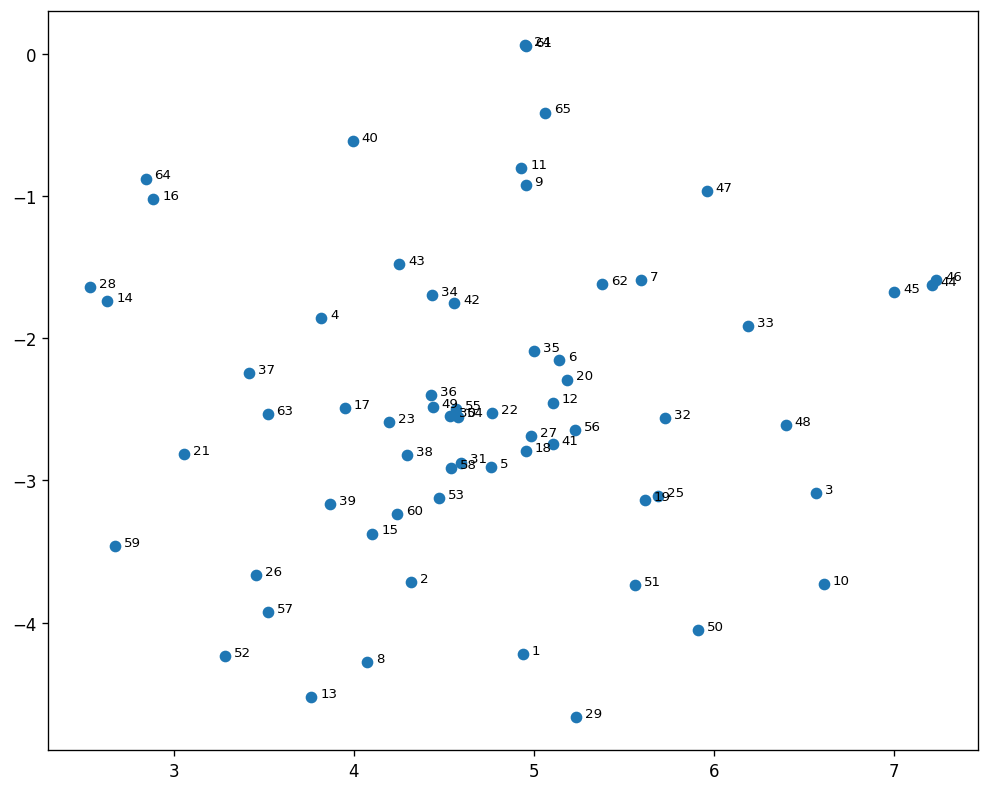

In [37]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=120)

tsne_model = TSNE(n_components=2, random_state=42)

reduced_emb = tsne_model.fit_transform(np.array(list(topic_emb_large_dict.values())))
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i], fontsize=8)
plt.show()

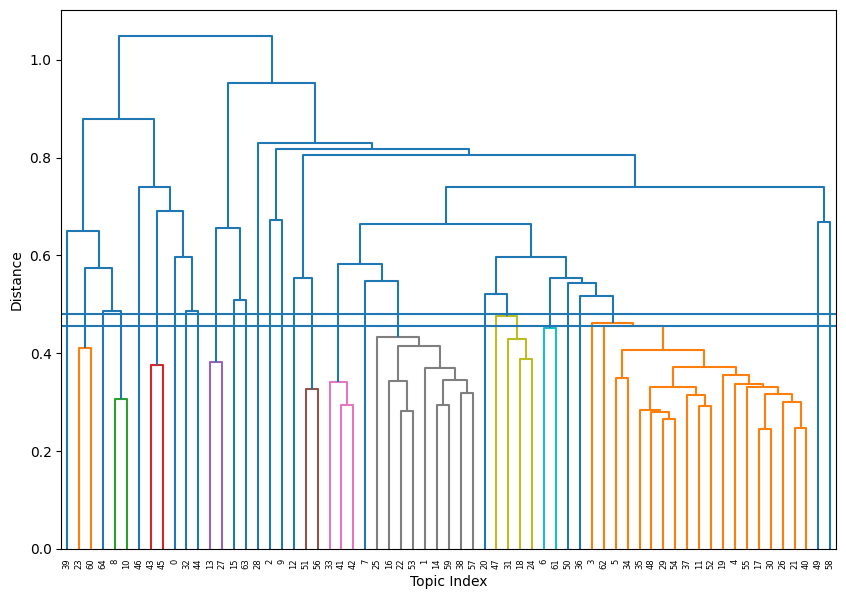

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

df = pd.DataFrame(np.array(list(topic_emb_large_dict.values())))
dist_matrix = pdist(df)
linkage_matrix = linkage(dist_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, 
           color_threshold=0.48, 
          )
plt.axhline(y=0.48)
plt.axhline(y=0.456)
# plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.savefig("hier_clus.png")
plt.show()

In [39]:
from scipy.cluster.hierarchy import fcluster

max_d = 0.48  # max_d defines the cut-off height
clusters = fcluster(linkage_matrix, max_d, criterion='distance')
len(clusters), clusters

(65,
 array([22,  9, 13, 18, 20, 20, 15, 10,  7, 14,  7, 20, 11,  1,  9,  2, 18,
        20, 19, 20, 24, 20, 18,  6, 19,  9, 20,  1, 28, 18, 20,  5, 25, 16,
        20, 18, 17, 18,  9,  5, 20, 16, 16,  4, 23,  4,  3, 26, 18, 27, 21,
         8, 20, 18, 18, 20,  8,  9, 12,  9,  6, 15, 20,  2,  7],
       dtype=int32))

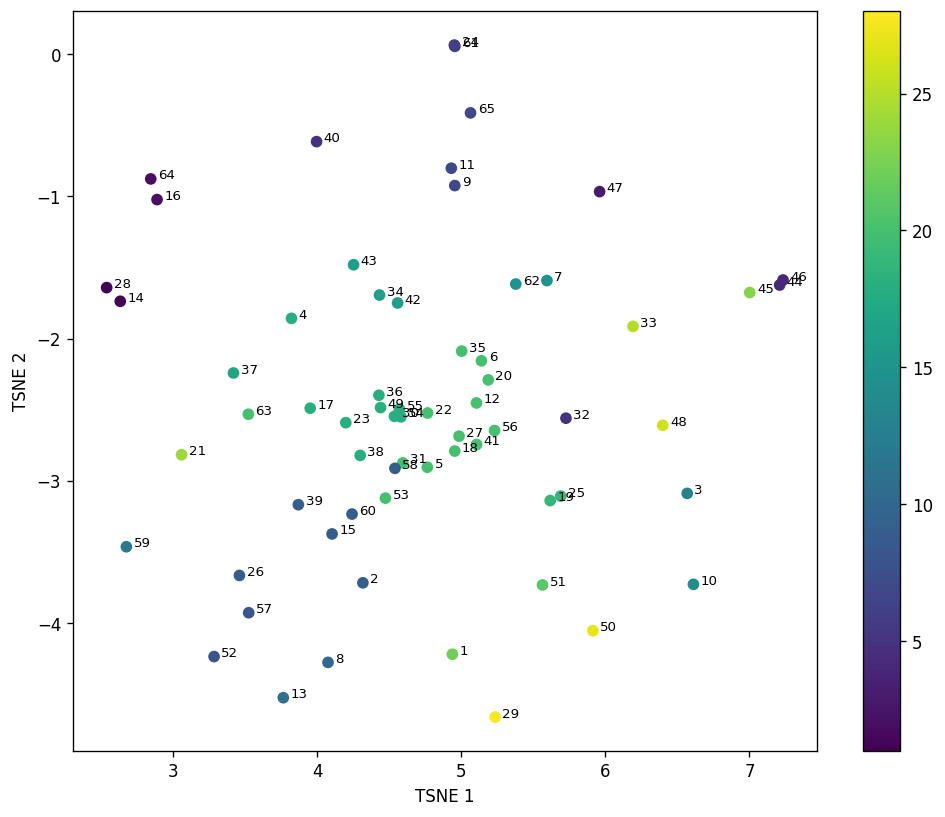

In [42]:
plt.figure(figsize=(10, 8), dpi=120)
scatter = plt.scatter(x_axis, y_axis, c=clusters,  cmap='viridis')
plt.colorbar(scatter)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i], fontsize=8)

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
# plt.savefi g("tsne_colored.png")
plt.show()

In [217]:
max_ds = np.linspace(0.3,1,80)
# max_ds = np.linspace(0.5,1,5)
scores = []
for max_d in max_ds:
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    # print(clusters)
    score = silhouette_score(reduced_emb, clusters)
    scores.append(score)
    print(max_d, score)

0.3 -0.084147364
0.30886075949367087 -0.10203828
0.31772151898734174 -0.10672116
0.3265822784810126 -0.06254665
0.33544303797468356 -0.049812116
0.34430379746835443 0.020430664
0.3531645569620253 0.052790057
0.3620253164556962 0.058281098
0.37088607594936707 0.08239136
0.37974683544303794 0.18435992
0.3886075949367088 0.21139629
0.39746835443037976 0.24052653
0.4063291139240506 0.24052653
0.4151898734177215 0.24052653
0.4240506329113924 0.24406767
0.43291139240506327 0.23691826
0.44177215189873414 0.23691826
0.450632911392405 0.24222308
0.4594936708860759 0.22570062
0.4683544303797468 0.22195901
0.4772151898734177 0.2483492
0.48607594936708853 0.2349534
0.49493670886075947 0.18054412
0.5037974683544304 0.18054412
0.5126582278481012 0.16096684
0.521518987341772 0.15190335
0.530379746835443 0.15190335
0.5392405063291139 0.13624878
0.5481012658227847 0.13624878
0.5569620253164557 0.13624878
0.5658227848101265 0.12744239
0.5746835443037974 0.12744239
0.5835443037974684 0.11378206
0.5924050

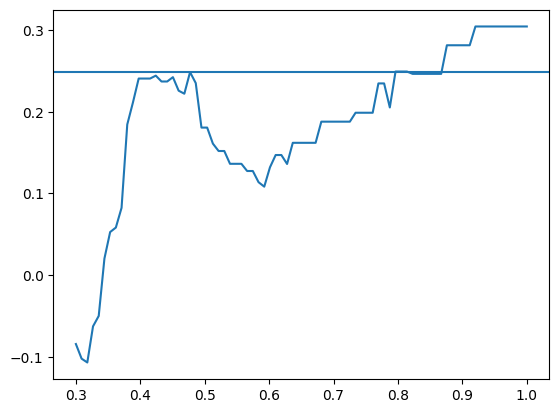

In [216]:
plt.plot(max_ds, scores)
plt.axhline(y=max(scores[:40]))

In [184]:
clusters

array([ 7,  6, 14,  6,  6,  6,  5,  4, 12, 15, 12,  6,  4,  1,  6,  2,  6,
        6,  6,  6,  8,  6,  6, 12,  6,  6,  6,  1, 10,  6,  6, 11,  8,  6,
        6,  6,  6,  6,  6, 11,  6,  6,  6, 13,  7, 13,  3,  8,  6,  8,  6,
        4,  6,  6,  6,  6,  4,  6,  9,  6, 12,  5,  6,  2, 12],
      dtype=int32)

In [185]:
from sklearn.metrics import silhouette_score


silhouette_score(reduced_emb, clusters)

0.13192286

In [202]:
print('hello')

hello


In [ ]:
def generate_embeddings(text, size="SMALL"): # model = "deployment_name"
    client = AzureOpenAI(
      api_key = os.getenv("AZURE_OPENAI_KEY"),  
      api_version = "2024-02-01",
      azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )
    
    return client.embeddings.create(input = [text], model=os.getenv(f"DEPLOYMENT_NAME_{size}")).data[0].embedding

In [ ]:
def download_emb(text, embedding_folder=f"{os.getenv('OAK')}/samori/tiktok/embeddings"):
    small_emb = generate_embeddings(text, size="SMALL")
    large_emb = generate_embeddings(text, size="LARGE")
    
    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
        emb_dict_small = pickle.load(f)
        emb_dict_small[text] = small_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
        emb_dict_large = pickle.load(f)
        emb_dict_large[text] = large_emb

    with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl","wb") as f:
        pickle.dump(emb_dict_small, f)

    with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl","wb") as f:
        pickle.dump(emb_dict_large, f)

    return (emb_dict_small, emb_dict_large)

In [ ]:
oak = os.getenv('OAK')
embedding_folder = f"{oak}/samori/tiktok/embeddings"

with open(f"{embedding_folder}/gensim_vocab_embedding_small.pkl", "rb") as f:
    emb_dict_small = pickle.load(f)

with open(f"{embedding_folder}/gensim_vocab_embedding_large.pkl", "rb") as f:
    emb_dict_large = pickle.load(f)

In [ ]:
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=65, id2word=id2word, random_seed=43)
optimal_gensim = convertldaMalletToldaGen(optimal_model)


topics = optimal_model.show_topics(num_topics=66, num_words=16861, formatted=False)
filtered_topics = {}
for i in range(len(topics)):
    topic_list = topics[i][1]
    word_dict = {i[0]: i[1] for i in topic_list}
    
    threshold = 0.80
    
    words = list(word_dict.keys())
    values = list(word_dict.values())

    cumsum = np.cumsum(values)
    n = np.argmin(cumsum <= threshold)

    
    filtered_dict = dict(zip(words[:n], values[:n]))
    filtered_topics[i] = filtered_dict

In [ ]:
topic_emb_small_dict = {}
topic_emb_large_dict = {}
for i in range(len(topics)):
    topic_dict_i = filtered_topics[i]

    terms = list(topic_dict_i.keys())
    terms = [i.replace("_"," ") for i in terms]
    # print(terms)
    # break
    values = list(topic_dict_i.values())
    values = np.array(values) / np.sum(values)

    topic_emb_small = np.zeros(1536)
    topic_emb_large = np.zeros(3072)
    
    for term_id in range(len(terms)):
        try:
            topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
            topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])
        except KeyError:
            print(terms[term_id])
            emb_dict_small, emb_dict_large = download_emb(terms[term_id])
            topic_emb_small += values[term_id] * np.array(emb_dict_small[terms[term_id]])
            topic_emb_large += values[term_id] * np.array(emb_dict_large[terms[term_id]])

    topic_emb_small_dict[f"{i+1}"] = topic_emb_small
    topic_emb_large_dict[f"{i+1}"] = topic_emb_large

In [ ]:
df = pd.DataFrame(np.array(list(topic_emb_small_dict.values())))
dist_matrix = pdist(df)
linkage_matrix = linkage(dist_matrix, method='ward')

In [ ]:
test_ds = np.linspace(0.3,1,80)
# max_ds = np.linspace(0.5,1,5)
scores = []
for test_d in test_ds:
    clusters = fcluster(linkage_matrix, test_d, criterion='distance')
    # print(clusters)
    score = silhouette_score(reduced_emb, clusters)
    scores.append(score)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

df = pd.DataFrame(np.array(list(topic_emb_small_dict.values())))
dist_matrix = pdist(df)
linkage_matrix = linkage(dist_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, 
           color_threshold=0.48, 
          )
plt.axhline(y=0.48)
plt.axhline(y=0.456)
# plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

max_d = 0.48  # max_d defines the cut-off height
clusters = fcluster(linkage_matrix, max_d, criterion='distance')
len(clusters), clusters

In [ ]:
plt.figure(figsize=(10, 8), dpi=120)
scatter = plt.scatter(x_axis, y_axis, c=clusters,  cmap='viridis')
plt.colorbar(scatter)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i], fontsize=8)

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
# plt.savefi g("tsne_colored.png")
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=120)

tsne_model = TSNE(n_components=2, random_state=42)

reduced_emb = tsne_model.fit_transform(np.array(list(topic_emb_large_dict.values())))
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i], fontsize=8)
plt.show()

In [173]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X, y = make_blobs(random_state=42)
kmeans = KMeans(n_clusters=2, random_state=42)
silhouette_score(X, kmeans.fit_predict(X))

0.496137786540463

In [178]:
X.shape, kmeans.fit_predict(X)

((100, 2),
 array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int32))

/home/groups/rbaltman/samori/miniconda3/envs/lda_env2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


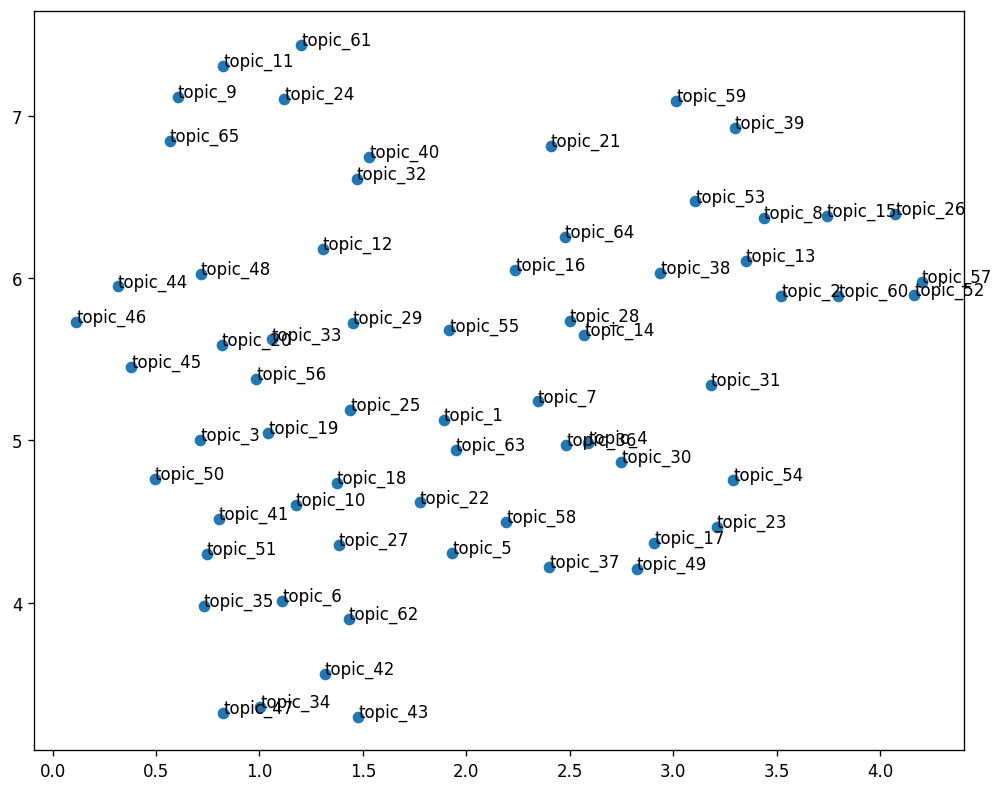

In [32]:
from umap import UMAP
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=120)

umap_model = UMAP(n_components=2, random_state=42)

reduced_emb = umap_model.fit_transform(np.array(list(topic_emb_small_dict.values())))
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i], y_axis[i], labels[i])
plt.show()

/home/groups/rbaltman/samori/miniconda3/envs/lda_env2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


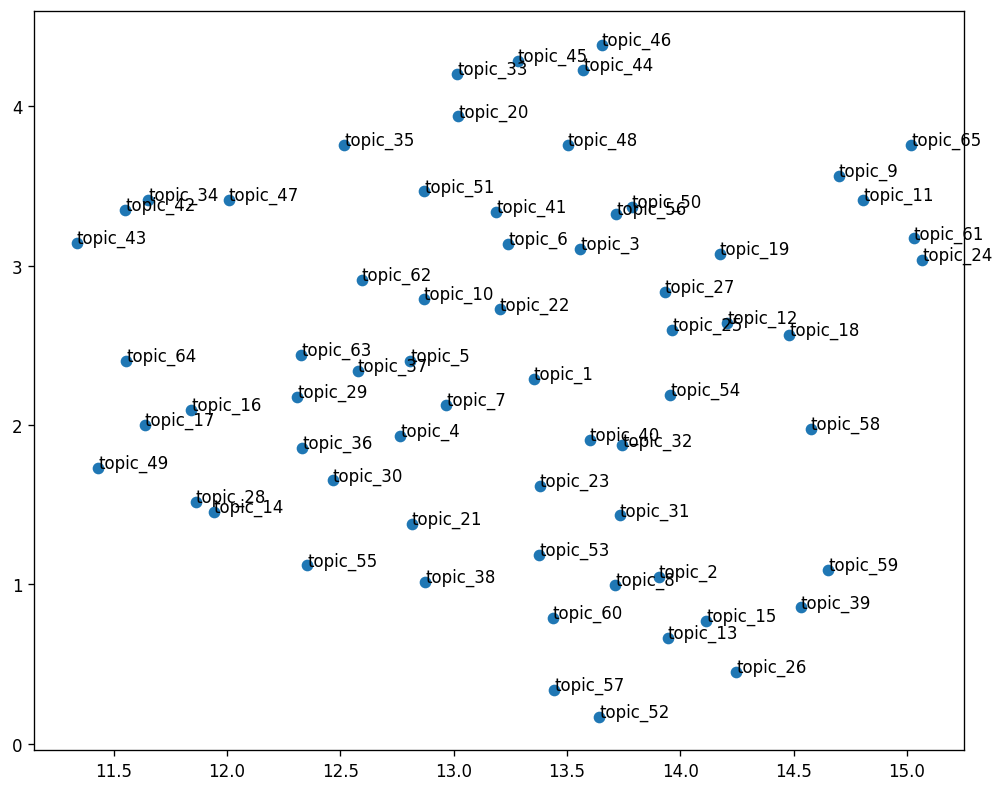

In [31]:
plt.figure(figsize=(10, 8), dpi=120)

umap_model = UMAP(n_components=2, random_state=42)

reduced_emb = umap_model.fit_transform(np.array(list(topic_emb_large_dict.values())))
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i], y_axis[i], labels[i])
plt.show()

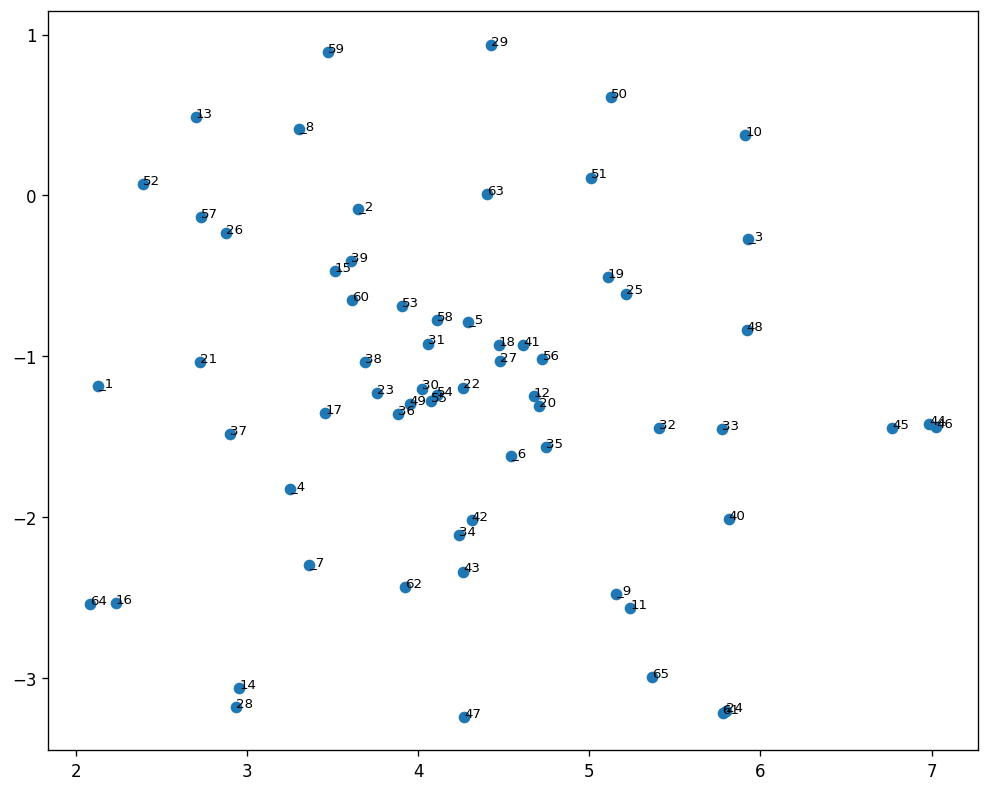

In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8), dpi=120)

umap_model = TSNE(n_components=2, random_state=42)

reduced_emb = umap_model.fit_transform(np.array(list(topic_emb_large_dict.values())))
x_axis = reduced_emb[:,0]
y_axis = reduced_emb[:,1]
labels = list(topic_emb_small_dict.keys())

plt.scatter(x_axis, y_axis)
for i in range(len(labels)):
    plt.text(x_axis[i], y_axis[i], labels[i][-2:], fontsize=8)
plt.show()

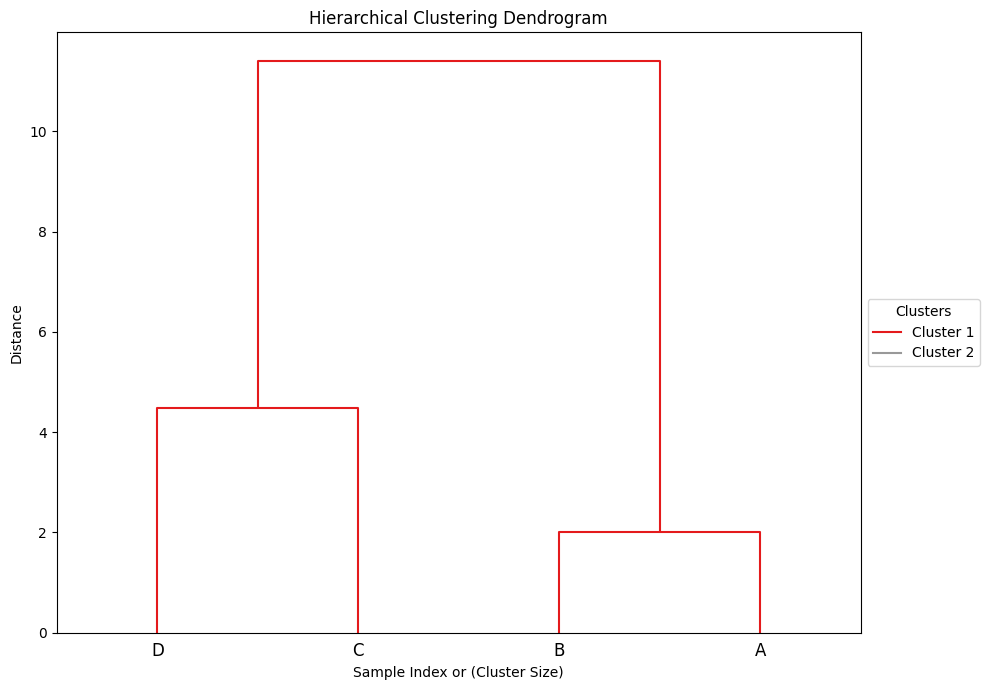

In [147]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Your existing code for creating X and calculating Z
X = np.array([[1, 2], [1, 4], [10, 6], [6, 8]])
Z = linkage(X, 'ward')

# Perform flat clustering
t = 5  # Adjust this threshold as needed
clusters = fcluster(Z, t, criterion='distance')

# Create a color map
n_clusters = len(np.unique(clusters))
color_map = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_clusters))

# Function to assign colors to links
def link_color_func(k):
    if k < len(Z):  # Check if k is within the bounds of Z
        c1, c2 = int(Z[k, 0]), int(Z[k, 1])
        # Determine the color based on the smaller of the two merged clusters
        c = min(c1, c2)
        if c < len(X):
            return mcolors.rgb2hex(color_map[clusters[c] - 1])
    # For k out of bounds or for merges above clustering level, use a default color
    return mcolors.rgb2hex(color_map[0])

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, 
           orientation='top', 
           labels=['A', 'B', 'C', 'D'],
           distance_sort='descending',
           show_leaf_counts=True,
           link_color_func=link_color_func)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')

# Add a legend
for i in range(n_clusters):
    plt.plot([], [], color=mcolors.rgb2hex(color_map[i]), label=f'Cluster {i+1}')
plt.legend(title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

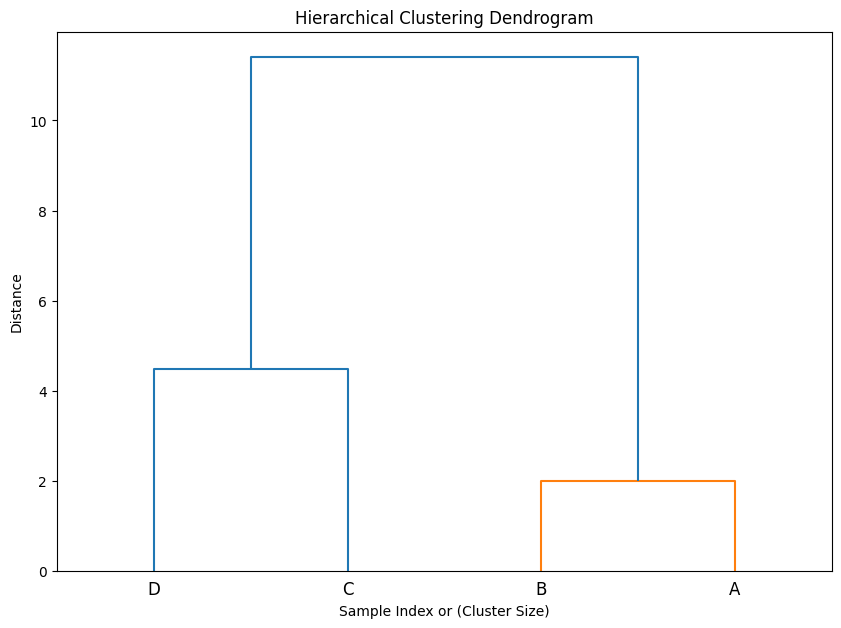

In [69]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# Create a dataset
X = np.array([[1, 2], [1, 4], [10, 6], [6, 8]])

# Calculate the linkage matrix
Z = linkage(X, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, 
           orientation='top', 
           labels=['A', 'B', 'C', 'D'],
           distance_sort='descending',
           show_leaf_counts=True,
          color_threshold=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Generate sample data
np.random.seed(0)
X = np.random.rand(10, 2)

# Compute linkage matrix
Z = linkage(X, method='ward')

# Get flat clusters using fcluster
k = 3  # Number of desired clusters
clusters = fcluster(Z, k, criterion='maxclust')

# Create a color map for the clusters
from matplotlib import cm
cmap = cm.get_cmap('viridis', k)

def plot_dendrogram(Z, **kwargs):
    plt.figure(figsize=(10, 5))
    dendrogram(
        Z,
        **kwargs,
        link_color_func=lambda k: cmap(clusters[k] - 1)  # Color links by cluster
    )
    plt.show()

plot_dendrogram(Z)

IndexError: index 12 is out of bounds for axis 0 with size 10

<Figure size 1000x500 with 0 Axes>

In [140]:
dumm = []

In [141]:
# Perform flat clustering
t = 0.6  # Adjust this threshold as needed
clusters = fcluster(linkage_matrix, t, criterion='distance')

# Create a color map
n_clusters = len(np.unique(clusters))
color_map = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_clusters))

# Function to assign colors to links
def link_color_func(k):
    dumm.append(k)
    if k == 65:
        
        return mcolors.rgb2hex(color_map[0])
    else:
        print(f"*****{k}*****")
        return mcolors.rgb2hex(color_map[-1])
    # X = np.array(list(topic_emb_small_dict.values()))
    # Z = linkage_matrix
    # if k < len(X):  # original points
    #     return mcolors.rgb2hex(color_map[clusters[k] - 1])
    # else:  # merges
    #     c1, c2 = int(Z[k-len(X), 0]), int(Z[k-len(X), 1])
    #     # Use the smaller index to determine color
    #     c = min(c1, c2)
    #     if c < len(clusters):
    #         return mcolors.rgb2hex(color_map[clusters[c] - 1])
    #     else:
    #         # If we're above the clustering level, use a default color
    #         return mcolors.rgb2hex(color_map[0])  # or any default color

In [144]:
len(dumm)

64

*****86*****
*****101*****
*****117*****
*****121*****
*****77*****
*****108*****
*****112*****
*****98*****
*****74*****
*****76*****
*****81*****
*****88*****
*****90*****
*****95*****
*****66*****
*****70*****
*****72*****
*****67*****
*****84*****
*****91*****
*****97*****
*****104*****
*****71*****
*****80*****
*****103*****
*****89*****
*****69*****
*****75*****
*****85*****
*****68*****
*****73*****
*****79*****
*****82*****
*****87*****
*****92*****
*****93*****
*****99*****
*****102*****
*****106*****
*****111*****
*****114*****
*****115*****
*****122*****
*****109*****
*****105*****
*****107*****
*****113*****
*****116*****
*****120*****
*****123*****
*****124*****
*****96*****
*****94*****
*****78*****
*****100*****
*****110*****
*****119*****
*****83*****
*****118*****
*****125*****
*****126*****
*****127*****
*****128*****


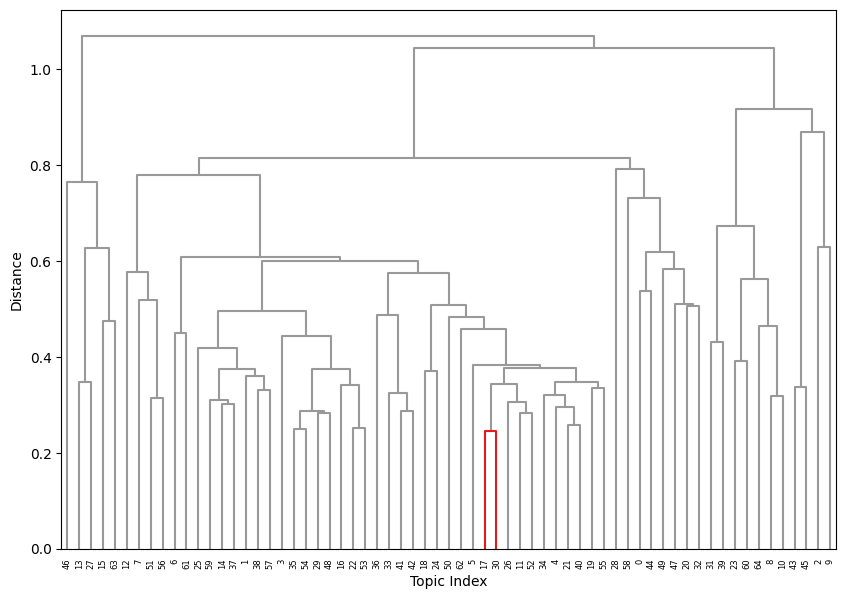

In [142]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

df = pd.DataFrame(np.array(list(topic_emb_small_dict.values())))
dist_matrix = pdist(df)
linkage_matrix = linkage(dist_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, 
           # color_threshold=0.8, 
           link_color_func=link_color_func,
          )
# plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Topic Index')
plt.ylabel('Distance')
plt.savefig("hier_clus.png")
plt.show()

In [65]:
Z

array([[ 0.        ,  1.        ,  2.        ,  2.        ],
       [ 2.        ,  3.        ,  4.47213595,  2.        ],
       [ 4.        ,  5.        , 11.40175425,  4.        ]])

In [53]:
from scipy.cluster.hierarchy import fcluster

max_d = 0.6  # max_d defines the cut-off height
clusters = fcluster(linkage_matrix, max_d, criterion='distance')
len(clusters), clusters

(65,
 array([ 7,  6, 14,  6,  6,  6,  5,  4, 12, 15, 12,  6,  4,  1,  6,  2,  6,
         6,  6,  6,  8,  6,  6, 12,  6,  6,  6,  1, 10,  6,  6, 11,  8,  6,
         6,  6,  6,  6,  6, 11,  6,  6,  6, 13,  7, 13,  3,  8,  6,  8,  6,
         4,  6,  6,  6,  6,  4,  6,  9,  6, 12,  5,  6,  2, 12],
       dtype=int32))

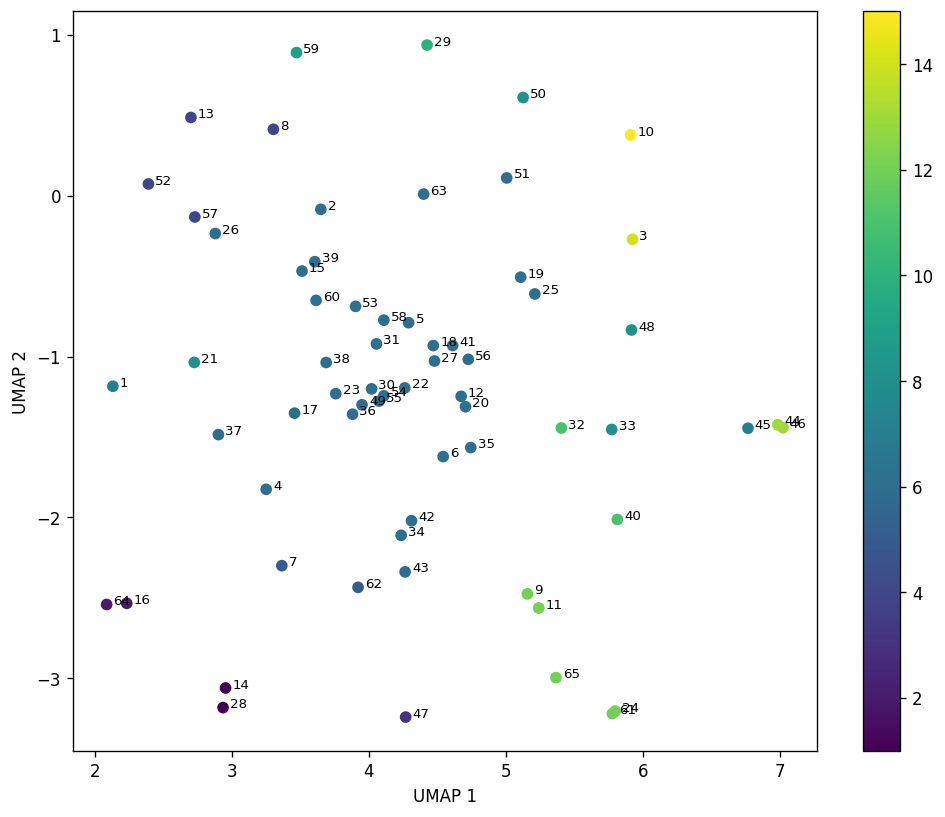

In [54]:
plt.figure(figsize=(10, 8), dpi=120)
scatter = plt.scatter(x_axis, y_axis, c=clusters,  cmap='viridis')
plt.colorbar(scatter)
for i in range(len(labels)):
    plt.text(x_axis[i]+0.05, y_axis[i], labels[i].split("_")[-1], fontsize=8)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig("tsne_colored.png")
plt.show()

In [64]:
import math

linkage_matrix

array([[ 17.        ,  30.        ,   0.24653574,   2.        ],
       [ 35.        ,  54.        ,   0.24969721,   2.        ],
       [ 22.        ,  53.        ,   0.25125455,   2.        ],
       [ 21.        ,  40.        ,   0.25738738,   2.        ],
       [ 11.        ,  52.        ,   0.28228064,   2.        ],
       [ 29.        ,  48.        ,   0.28300651,   2.        ],
       [ 41.        ,  42.        ,   0.28643059,   2.        ],
       [ 66.        ,  70.        ,   0.28820568,   4.        ],
       [  4.        ,  68.        ,   0.29642992,   3.        ],
       [ 14.        ,  37.        ,   0.30106383,   2.        ],
       [ 26.        ,  69.        ,   0.3059003 ,   3.        ],
       [ 59.        ,  74.        ,   0.30944159,   3.        ],
       [ 51.        ,  56.        ,   0.31498438,   2.        ],
       [  8.        ,  10.        ,   0.31910431,   2.        ],
       [ 34.        ,  73.        ,   0.3198439 ,   4.        ],
       [ 33.        ,  71

In [86]:
sum = 0
n = 64
for i in range(1, n+1):
    sum += i
    
print(sum)

2080


In [70]:
a = np.cumsum(values)
idx = a <= 0.80

for j in range(len(idx)):
    print(j, idx[j], a[j])

0 True 0.3864236027824418
1 True 0.5169105301031423
2 True 0.5742384264811705
3 True 0.6001439194051331
4 True 0.6226912928759895
5 True 0.6428400095946271
6 True 0.6625089949628209
7 True 0.6781002638522429
8 True 0.6915327416646679
9 True 0.7042456224514273
10 True 0.7155193091868555
11 True 0.7263132645718399
12 True 0.7359078915807149
13 True 0.7455025185895899
14 True 0.7529383545214681
15 True 0.7598944591029024
16 True 0.766610698009115
17 True 0.7721276085392181
18 True 0.7776445190693213
19 True 0.7831614295994245
20 True 0.7884384744543057
21 True 0.7934756536339651
22 True 0.7982729671384026
23 False 0.8021108179419526
24 False 0.8059486687455026
25 False 0.8097865195490527
26 False 0.8133845046773808
27 False 0.816742624130487
28 False 0.8201007435835933
29 False 0.8234588630366996
30 False 0.8268169824898058
31 False 0.8294555049172465
32 False 0.8320940273446872
33 False 0.8347325497721279
34 False 0.8371312065243466
35 False 0.8392899976013435
36 False 0.8414487886783404

In [53]:
values[106], values[88]

(0.0007279786459597186, 0.0007279786459597186)

In [32]:
np.sum(list(word_dict.values())[:15])

0.6832116788321166

In [40]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)],
 [(12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1)],
 [(19, 1), (20, 1)],
 [(21, 1)],
 [(21, 1), (22, 1)],
 [(23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1)],
 [(38, 1),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1)],
 [(48, 1), (49, 1), (50, 1), (51, 1)],
 [(21, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(35, 1), (50, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)],
 [(65, 1), (66, 1), (67, 1), (68, 1)],
 [(69, 1), (70, 1), (71, 1)],
 [(72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1)],
 [(79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1)],
 [(9, 1),
  (78, 1),
  (89, 1),
  (90, 1),

In [ ]:
from collections import Counter
from itertools import chain

def corpus_probabilities(corpus):
    word_counts = Counter(chain.from_iterable(corpus))
    total_words = sum(word_counts.values())
    return {word: count / total_words for word, count in word_counts.items()}

probs = corpus_probabilities(your_corpus)
print(f"Probability of 'example': {probs['example']}")

In [44]:
from collections import Counter
from itertools import chain

word_counts = Counter(chain.from_iterable(corpus))
len(word_counts)

18699

In [39]:
for i in range(3):
    topic_list = topics[i][1]
    word_dict = {i[0]: i[1] for i in topic_list}
    total = np.sum(list(word_dict.values())[:20])
    print(word_dict, '\n\n\n')

{'give': 0.3864236027824418, 'high': 0.1304869273207004, 'dose': 0.057327896378028306, 'school': 0.025905492923962582, 'tylenol': 0.02254737347085632, 'low': 0.020148716718637563, 'advice': 0.019668985368193812, 'tolerance': 0.015591268889421923, 'chill': 0.013432477812425042, 'function': 0.012712880786759414, 'chance': 0.01127368673542816, 'expect': 0.010793955384984408, 'ibuprofen': 0.00959462700887503, 'build': 0.00959462700887503, 'birth': 0.0074358359318781484, 'horse': 0.006956104581434397, 'tramadol': 0.006716238906212521, 'offer': 0.005516910530103142, 'plenty': 0.005516910530103142, 'vibe': 0.005516910530103142, 'present': 0.005277044854881266, 'ketamine': 0.005037179179659391, 'extremely': 0.004797313504437515, 'aggressive': 0.003837850803550012, 'section': 0.003837850803550012, 'cat': 0.003837850803550012, 'motrin': 0.003597985128328136, 'protocol': 0.0033581194531062605, 'mention': 0.0033581194531062605, 'hr': 0.0033581194531062605, 'nod': 0.0033581194531062605, 'painkiller